
# MSCF 46982 Market Microstructure and Algorithmic Trading

Fall 2025 Mini 2

Probability of Informed Trading

Copyright &copy; 2025 Nick Psaris. All Rights Reserved

# TOC
- [Initialize](#Initialize)
- [Informed vs. Uninformed Trading](#Informed-vs.-Uninformed-Trading)
- [Probability of Informed Trading (PIN)](#Probability-of-Informed-Trading-(PIN))
- [The PIN Model](#The-PIN-Model)
- [PIN Model Assumptions](#PIN-Model-Assumptions)
- [PIN Model Derivation](#PIN-Model-Derivation)
- [PIN Factorization](#PIN-Factorization)
- [Buy-Sell Labeling](#Buy-Sell-Labeling)
- [PIN Calculation](#PIN-Calculation)
- [PIN Log Likelihood](#PIN-Log-Likelihood)
- [PIN Parameter Optimization](#PIN-Parameter-Optimization)
- [PIN Problems](#PIN-Problems)
- [Volume Synchronized PIN (VPIN)](#Volume-Synchronized-PIN-(VPIN))
- [VPIN Time Bars](#VPIN-Time-Bars)
- [VPIN Volume Bin Size](#VPIN-Volume-Bin-Size)
- [VPIN Volume Bins](#VPIN-Volume-Bins)
- [VPIN Volume Assignment](#VPIN-Volume-Assignment)
- [VPIN Computation](#VPIN-Computation)
- [VPIN Problems](#VPIN-Problems)
- [VPIN Timeseries Chart](#VPIN-Timeseries-Chart)
- [Further Reading](#Further-Reading)

# Initialize
- Initialize the number of rows and columns displayed
- Create NYSE Daily TAQ Kdb+ database connection handle `h`
- Import required python libraries
- Set plotting defaults

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
\c 25 200
/ windows and mac/linux use different environment variables
home:`HOME`USERPROFILE "w"=first string .z.o
upf:0N!` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5000:",first read0 upf


`:/Users/nick/cmu_userpass.txt


In [3]:
%%py
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]


# Informed vs. Uninformed Trading

Markets require a combination of informed traders who are compensated
for their skill, and uninformed traders who are willing to pay for
someone else' skill.

[Grossman & Stiglitz (1980)][] conclude:

> ... that because information is costly, prices cannot perfectly
> reflect the information which is available, since if it did, those
> who spent resources to obtain it would receive no compensation.

[Grossman & Stiglitz (1980)]: http://www.jstor.org/stable/1805228 "Grossman & Stiglitz (1980)"


## Informed Trading
- Smarter (better research)
- Faster (better software/hardware)
- Insider (illegal access to information)

## Uninformed trading
- Consumption delays/demands
- Asset in/out flows
- Portfolio rebalance
- Incorrect belief of being informed

## Evidence of  informed trading 
- Irregular buy/sell volumes
- Anything else?

# Probability of Informed Trading (PIN)
- The risk an uninformed trader experiences when trading with an
  informed trader helps determine prices
- Easley, O’Hara, et al. have proposed a model to determine the
  likelihood that a stock is trading with informed participants
- The only input required is the number of buy and sell trades for a
  given period
- Though we don't readily have this data, we can use the Lee-Ready
  algorithm to *estimate* the number of buyer and seller initiated
  trades


# The PIN Model
- Assume a market is composed of indistinguishable informed and
  uninformed traders
- Risk neutral market makers provide continuous quotes that factor in
  known information
- Prior to each trading day, 'nature' determines if there is an
  information event

## The PIN model parameters

- Information events occur with probability $\alpha$
- Information events do not occur with probability $1-\alpha$
- Given an information event
  + Bad news occurs with probability $\delta$
  + Good news occurs with probability $1-\delta$

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/1/1f/PIN_Model_1996.JPG" width="500"/>
</div>

# PIN Model Assumptions
- Each trading day is independent
- Information events occur outside trading hours
- Information is incorporated by market close
- Only one type of information event exists (with a specific intensity)
- At most one information event can occur for each trading day
- Market maker knows the probability of the events, but not which one
  is realized
- **Market maker learns which event is realized through trading**
- Both informed traders and uninformed traders enter the market
  following independent Poisson processes
- Information events cause informed traders to enter the market
- Information events arrive following a Poisson process

# PIN Model Derivation
- Uninformed traders enter the market at a rate of $\epsilon$ for
  buyers and sellers (split into $\epsilon_b$ and $\epsilon_s$ for a
  more complicated model)
- Informed traders enter the market at a rate of $\mu$ and bad news
  occurs with a probability of $\delta$

## Derivation of PIN statistic
- The probability of informed trading is the ratio of the expected
  *informed trading intensity* to the *total trading intensity*:
  
$$
\text{PIN} = \frac{ \alpha\delta\mu + \alpha(1-\delta)\mu }
  {(1-\alpha)2\epsilon + \alpha\delta2\epsilon + \alpha(1-\delta)2\epsilon +
  \alpha\delta\mu + \alpha(1-\delta)\mu}
  $$

which simplifies to:

$$
\text{PIN} =\frac{\alpha\mu}{2\epsilon+\alpha\mu}
$$

- Notice how $\delta$ cancels out and is not needed to compute the
  probability of *informed* trading
- On a good news day, the combined rates are $\mu+\epsilon$ for buy
  orders and only $\epsilon$ for sell orders
- On a bad news day, the combined rates are $\mu+\epsilon$ for sell
  orders and only $\epsilon$ for buy orders
- On a non-event day, the rate is only $\epsilon$ and $\epsilon$
  for buy and sell orders

## Derivation of the likelihood function
- The Probability of seeing B buy and S sell trades on a non-event date is:
$$
e^{-\epsilon}\frac{\epsilon^{B_d}}{B_d!}e^{-\epsilon}\frac{\epsilon^{S_d}}{S_d!}
$$
- The probability of seeing B buy and S sell trades on a good news date is:
$$
e^{-(\mu+\epsilon)}\frac{(\mu+\epsilon)^{B_d}}{B_d!}e^{-\epsilon}\frac{\epsilon^{S_d}}{S_d!}
$$
- And the probability of seeing B buy and S sell trades on a bad news date is:
$$
e^{-\epsilon}\frac{\epsilon^{B_d}}{B_d!}e^{-(\mu+\epsilon)}\frac{(\mu+\epsilon)^{S_d}}{S_d!}
$$

- Weighting by the probability of non event, good news, and bad news
days results in the likelihood of observing B buys and S sells as:

$$
\begin{align} \mathcal{L}((B,S)|\Theta) &= (1-\alpha) & e^{-\epsilon} &
\frac{\epsilon^{B_d}}{B_d!} & e^{-\epsilon} & \frac{\epsilon^{S_d}}{S_d!} \\
&+ \alpha(1-\delta) & e^{-(\mu+\epsilon)} &
\frac{(\mu+\epsilon)^{B_d}}{B_d!} & e^{-\epsilon} & \frac{\epsilon^{S_d}}{S_d!} \\
&+ \alpha\delta
& e^{-\epsilon} & \frac{\epsilon^{B_d}}{B_d!} & e^{-(\mu+\epsilon)} & \frac{(\mu+\epsilon)^{S_d}}{S_d!}
\end{align}
$$

where $\theta$ is the parameter vector $\epsilon$, $\mu$, $\alpha$,
  $\delta$ (or $\epsilon_b$ and $\epsilon_s$ for a more complicated
  model)


- Since each day is assumed independent, the likelihood across J days
  would be the product of multiple instances of this single day
  likelihood

$$
\mathcal{L}(M|\Theta) = \prod_{j=1}^{J} \mathcal{L}((B_j,S_j)|\theta)
$$
  
- To ease calculation, we convert the likelihood into a
  log-likelihood. The products turn into summations and the common
  additive factor of $−\log(B_d!S_d!)$ can be dropped when we perform
  parameter estimation
- Easley et al (1996) note that quarterly data (approximately 60
  trading days) provides the best tradeoff between having enough
  observations and ensuring the trading dynamics remain unchanged.
  

# PIN Factorization

- The original derivation of these equations was inefficient and
  unstable due to numerical overflow and underflow
- Raising values to the power of B and S causes problems with highly
  liquid instruments


## [Easley, Hvidkjaer and O’Hara (2010)][EHO] ### 
- EHO refactored the log likelihood equation to address these issues

[EHO]: https://doi.org/10.1017/S0022109010000074 "Easley, Hvidkjaer and O’Hara (2010)"


$$
\begin{align}
\log \mathcal{L}(M|\Theta) &= \sum_{d=1}^n -2\epsilon + M_d \log x + (B_d+S_d)\log(\mu + \epsilon) \\
&+ \sum_{d=1}^n \log \left( (1-\alpha)x^{S_d+B_d-M_d} + \alpha(1-\delta)\exp(-\mu)x^{S_d-M_d} + \alpha\delta\exp(-\mu)x^{B_d-M_d}\right)
\end{align}
$$

where:

$$
\begin{align}
M_d &= \min(B_d,S_d) + .5 \max(B_d,S_d) \\
x &= \frac{\epsilon}{\epsilon + \mu}
\end{align}
$$

## [Lin and Ke (2011)][LK]

- LK found biases when B and S are very high that led to lower PIN
  values
- LK proposed a new refactorization which fixed the biases and
  improved numerical stability as well (see homework assignment!).

[LK]: https://doi.org/10.1016/j.finmar.2011.03.001 "Lin and Ke (2011)"


## [Ersan, Oguz (2016)][ERSAN]
- Ersan introduces the concept of Multilayer Probability of Informed
  Trading (MPIN)
- Instead of a single information event trading intensity $\mu$, Ersan
  permits multiple event types (layers) -- each with their own intensity
- The paper provides yet another factorization that easily extends to multiple layers

> When compared to PIN, MPIN yields substantially higher probabilities
> of informed trading and information event occurrence, and much lower
> rate of informed traders.

[ERSAN]: https://dx.doi.org/10.2139/ssrn.2874420 "Ersan, Oguz (2016)"


# Buy-Sell Labeling
- Implement `lr` to accept a list of syms and a **single** date
- No need to query the sizes from the trade table
- No need to filter on anything other than `date` from the `nbbo` table
- Reduce the network traffic by only returning the number of buy and sell trades per date/symbol
- Include the `date` column in the returned table so it can be merged with the other results

In [4]:
lr:{[s;dt]
 t:select date,sym,time,price from trade where date=dt,sym = s,null cond;
 t:aj[`sym`time;t]select sym,time,bid,ask from nbbo where date=dt;
 t:update mid:.5*ask+bid,tick:fills -1 0N 1@1+signum deltas[first price;price] from t;
 t:update side:?[price>mid;1;?[price<mid;-1;tick]] from t;
 t:0!select B:sum side>0, S:sum side<0 by date from t;
 t}

## Aggregate multi-day Lee-Ready
- Call `lr` multiple times - once for each day of the month - and `raze` the results

In [5]:
10#t:raze (h (lr;`CROX),) each 2020.02.03+til 28

date       B    S   
--------------------
2020.02.03 1655 1967
2020.02.04 1680 1477
2020.02.05 883  590 
2020.02.06 552  563 
2020.02.07 1031 1079
2020.02.10 1258 1883
2020.02.11 1154 1754
2020.02.12 1227 1295
2020.02.13 1245 898 
2020.02.14 962  999 


- Optionally scale values down to prevent numeric over/under-flow which
  is highly problematic in this model
- Copy the B and S vectors over to python


In [6]:
scale:.01f
.pykx.set[`B] get `B set scale*t`B
.pykx.set[`S] get `S set scale*t`S
p)if isinstance(B,list): B=np.array(B) 
p)if isinstance(S,list): S=np.array(S)

# PIN Calculation
- We first implement the `pin` function (first in Kdb+ and then in
  python) which requires the following four parameters: $\epsilon$,
  $\mu$, $\alpha$, $\delta$

$$
\frac{\alpha\mu}{2\epsilon+\alpha\mu}
$$


## Q implementation
- Variables declared on the right can be used on the left

In [7]:
pin:{[emad]am%(2*emad[0])+am:emad[2]*emad[1]}
emad:10000 1 .5 .5
pin emad

2.499938e-05


## Python implementation
- Variables declared on the left can be used on the right
- But only a *lambda* can be written on a single line

In [8]:
%%py
def pin(emad):
   return (am:=emad[2]*emad[1])/(2*emad[0]+am)
emad=[10000,1,.5,.5]
print(pin(emad))


2.499937501562461e-05


# PIN Log Likelihood
- Next we implement the pin log likelihood function based on EHO
  factorization
- It is important to recognize that $\epsilon$, and $\mu$ have
  a lower bound of 0, but have no upper bound
- In addition, the $\alpha, \delta$ parameters are probabilities, and
  are therefore bounded between 0 and 1


## Q implementation
- KDB+ 4.1 has extended assignment to allow multiple assignment
- Q will automatically expand a list of arguments: `(e;m;a;d)`
- Or you can do it explicitly: `(e;m;a;d):emad`

In [9]:
pinll_eho:{[(e;m;a;d);B;S]
 M:(B&S)+.5*B|S;
 x:e%m+e;
 ll:sum (-2*e)+(M*log[x])+(B+S)*log[e+m];
 ll+:sum log ((1-a)*x xexp B+S-M)+((a*1-d)*exp[neg m]*x xexp S-M)+(a*d*exp[neg m]*x xexp B-M);
 ll}
pinll_eho[emad;B;S]

-372517.9


## Python implementation
- Look how similar it is to Q when we vectorize all calculations
- Python has **sequence unpacking** too

In [10]:
%%py
def pinll_eho(emad,B,S):
 e, m, a, d = emad
 M=np.minimum(B,S)+.5*np.maximum(B,S)
 x=e/(m+e)
 ll= np.sum((-2*e)+M*np.log(x)+(B+S)*np.log(e+m))
 ll+=np.sum(np.log((1-a)*x**(B+S-M)+a*(1-d)*np.exp(-m)*x**(S-M)+a*d*np.exp(-m)*x**(B-M)))
 return ll
print(pinll_eho(emad,B,S))

-372517.9107043451


# PIN Parameter Optimization

- The [scipy.optimize][SPO] package only has a 'minimize' function, so
  we need to create a new objective function which is the negative of
  the log likelihood
- The optimize function requires that each of our fitted parameters be
  a single argument to our function, so we label it `emad`
- It is possible to pass the fixed `B` and `S` arguments to the
  objective function by using the `args` parameter
- Since we know what the bounds of the variables are, we can supply
  them in the 'bounds' parameter
- The function requires a non-linear solver: we use the Nelder Mead method

[SPO]: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html "Scipy Optimize Documentation"


## Find optimal PIN parameters using EHO factorization
- `*` can be used in python to generate multiple copies
- `+` can be used in python to concatenate lists
- `functools.partial` can be used to partially apply a function


In [11]:
%%py
from functools import partial
def objective(emad,B,S):
  return -pinll_eho(emad,B,S)

bounds = [[0,None]]*2 + [[0,1]]*2
emad_0 = [10,1,.5,.5]

f = partial(minimize,objective,emad_0)
sol = f(args=(B,S),method='nelder-mead',bounds=bounds)


In [12]:
f:{[x;y]x+y}
f[1]

{[x;y]x+y}[1]


## Compute PIN
- `scipy.minimize` returns a solution that provides the "optimal"
  `emad` stored in `sol.x`
- Calling our `pin` function with these optimal values will produce
  the PIN statistic


In [13]:
%%py
print(sol)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1783.3346312825554
             x: [ 1.798e+01  6.493e+01  1.053e-01  0.000e+00]
           nit: 196
          nfev: 344
 final_simplex: (array([[ 1.798e+01,  6.493e+01,  1.053e-01,  0.000e+00],
                       [ 1.798e+01,  6.493e+01,  1.053e-01,  0.000e+00],
                       ...,
                       [ 1.798e+01,  6.493e+01,  1.053e-01,  0.000e+00],
                       [ 1.798e+01,  6.493e+01,  1.053e-01,  0.000e+00]]), array([-1.783e+03, -1.783e+03, -1.783e+03, -1.783e+03,
                       -1.783e+03]))


In [14]:
%%py
print(pin(sol.x))

0.15969907712201023


# PIN Problems
- Susceptible to floating point exceptions when volumes are high
- Dependence on accurately labeling buyer vs seller initiation
- Sensitivity of optimization to initial parameter values and chance
  of a boundary solution (partially addressed in the homework assignment)
- Only produces daily (not intraday) estimates

# Volume Synchronized PIN ([VPIN][VPIN])
- "The Microstructure of the “Flash Crash”: Flow Toxicity, Liquidity
  Crashes, and the Probability of Informed Trading" [paper][VPINPAPER]
  by David Easley, Maureen O’Hara and [Marcos López de Prado][MLDP]
- While PIN is a low-frequency estimator, VPIN is a high-frequency
  estimator
- Group trades into **volume bins**
- Work in trade time (not clock time)
- Keep counting trades until a fixed volume transpires
- Count the number of buy and sell trades within that time (down to
  the minute) and label window -1 or +1
- Compute a volume weighted average over the previous 50 bins
- CDF of VPIN reached [historically high levels][FLASHCRASH] one hour
  **before** the e-mini flash crash of May 6, 2010
- Ke and Lin again [suggest an improvement][VPINIMPROVEMENT]

[VPIN]: http://www.quantresearch.org/vpin.pdf "Volume Synchronized PIN"
[VPINPAPER]: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1695041 "VPIN Paper"
[MLDP]: http://www.quantresearch.info/ "Marcos López de Prado"
[FLASHCRASH]: https://en.wikipedia.org/wiki/2010_Flash_Crash#/media/File:Flash_Crash.jpg "Flash Crash"
[VPINIMPROVEMENT]: http://dx.doi.org/10.1561/104.00000047 "VPIN Improvement"


## VPIN Patents
- ELO obtained [patents][VPINPATENTS] for computing, hedging and
  crossing an "informed trading" metric

> The process of calculating the informed trading metric, executed by
> a processor, includes analyzing sets of trades of the security. The
> processor determines a magnitude of a difference between a volume of
> buy transactions and the volume of sell transactions in the
> plurality of trades. The processor then derives the informed trading
> metric based on the ratio of the determined difference magnitude to
> the total volume of analyzed trades.


[VPINPATENTS]: https://www.quantresearch.org/Patents.htm "VPIN-Based Patents"


# VPIN Time Bars
- We first down-scale the raw tick data into time bars
- We define volumes as notional and price change as
  returns to take stock splits into consideration


In [15]:
sym:`BAC
dt:2020.02.01
tb:{[tbar;s;dt]
 t:select time+date,price,size from trade where date=dt,sym = s,null cond;
 t:select open:first price,close:last price, volume:sum "j"$price*size by tbar xbar time from t;
 t}
t:raze (h (tb;0D00:01;sym),) each dt+til 30
10#t:delete open, close from update ret:log ratios[first open;close] from t

time                         | volume   ret          
-----------------------------| ----------------------
2020.02.03D09:30:00.000000000| 8147051  0.002874217  
2020.02.03D09:31:00.000000000| 4242304  0.0009059339 
2020.02.03D09:32:00.000000000| 5061177  -0.0006038648
2020.02.03D09:33:00.000000000| 3353594  0.00033519   
2020.02.03D09:34:00.000000000| 3948369  0.001626039  
2020.02.03D09:35:00.000000000| 7177667  0.0007532957 
2020.02.03D09:36:00.000000000| 4309569  0.0006022283 
2020.02.03D09:37:00.000000000| 2553130  -0.0006022283
2020.02.03D09:38:00.000000000| 4746617  0.001805598  
2020.02.03D09:39:00.000000000| 11226179 -0.0007519363


# VPIN Volume Bin Size

In [16]:
/ volume bin size
vbs:{[nd;nb;s;dts] / num days, num bin/day, symbol, dates
 t:select volume:sum "j"$price*size by date from trade where date in dts,sym = s,null cond;
 t:1_update adv:"j"$prev nd mavg volume from t;
 t:select date,vbs:adv div nb from t;
 t}
/ number of buckets
nb:50
10#v:h(vbs;21;nb;sym;dt+til 30)

date       vbs     
-------------------
2020.02.04 18600394
2020.02.05 17715504
2020.02.06 19457193
2020.02.07 18451002
2020.02.10 17050200
2020.02.11 15861510
2020.02.12 15655376
2020.02.13 15693767
2020.02.14 15187696
2020.02.18 14744571


# VPIN Volume Bins
## Join the volume bin size with the time bar data

In [17]:
10#t:(update time.date from t) ij 1!v

time                         | volume   ret           date       vbs     
-----------------------------| ------------------------------------------
2020.02.04D09:30:00.000000000| 12681808 0.02085568    2020.02.04 18600394
2020.02.04D09:31:00.000000000| 7580867  0.0007638114  2020.02.04 18600394
2020.02.04D09:32:00.000000000| 5147117  -0.002227679  2020.02.04 18600394
2020.02.04D09:33:00.000000000| 5459580  0.001041589   2020.02.04 18600394
2020.02.04D09:34:00.000000000| 4381671  -0.000595061  2020.02.04 18600394
2020.02.04D09:35:00.000000000| 4901722  0.001041125   2020.02.04 18600394
2020.02.04D09:36:00.000000000| 3270817  -0.0008923261 2020.02.04 18600394
2020.02.04D09:37:00.000000000| 4117234  0.0005949725  2020.02.04 18600394
2020.02.04D09:38:00.000000000| 3396880  -0.001934956  2020.02.04 18600394
2020.02.04D09:39:00.000000000| 3092079  0             2020.02.04 18600394


## Assign each time bar into volume bin(s)

In [18]:
/ given vbc: (list of (v)olume/(b)in assignments; (c)umulative bin volume)
/ v: bin (v)olume
/ and vbs: (v)olume (b)in (s)ize
/ assign the time bar into one or more volume bins and return the new (vb;c) pair
vbins:{[vbc;v;vbs]
 b:last over vb:vbc 0;          / current volume bin
 vc:v+c:vbc 1;                  / volume + cumulative volume
 bv:vbs*n:vc div vbs;           / volume of complete bins
 nvb:();                        / initialize new ab
 if[n;nvb,:flip (@[n#vbs;0;-;c];b+til n);v-:bv-c]; / append full bins
 nvb,:enlist (v;b+n);                              / remaining volume
 (vb,enlist nvb;vc-bv)}                            / append partial volume

/first vbins/[(1 1 2#0;0);1 2 5 0 20 4;4]
10#t:update vb:1_first vbins/[(1 1 2#0;0);volume;vbs] from t

time                         | volume   ret           date       vbs      vb                   
-----------------------------| ----------------------------------------------------------------
2020.02.04D09:30:00.000000000| 12681808 0.02085568    2020.02.04 18600394 ,12681808 0          
2020.02.04D09:31:00.000000000| 7580867  0.0007638114  2020.02.04 18600394 (5918586 0;1662281 1)
2020.02.04D09:32:00.000000000| 5147117  -0.002227679  2020.02.04 18600394 ,5147117 1           
2020.02.04D09:33:00.000000000| 5459580  0.001041589   2020.02.04 18600394 ,5459580 1           
2020.02.04D09:34:00.000000000| 4381671  -0.000595061  2020.02.04 18600394 ,4381671 1           
2020.02.04D09:35:00.000000000| 4901722  0.001041125   2020.02.04 18600394 (1949745 1;2951977 2)
2020.02.04D09:36:00.000000000| 3270817  -0.0008923261 2020.02.04 18600394 ,3270817 2           
2020.02.04D09:37:00.000000000| 4117234  0.0005949725  2020.02.04 18600394 ,4117234 2           
2020.02.04D09:38:00.000000000| 3396880  

## Ungroup time bars so we can we can later aggegate by bin

In [19]:
10#v:ungroup select time,ret,vbs,volume:vb[;;0],b:vb[;;1] from t

time                          ret           vbs      volume   b
---------------------------------------------------------------
2020.02.04D09:30:00.000000000 0.02085568    18600394 12681808 0
2020.02.04D09:31:00.000000000 0.0007638114  18600394 5918586  0
2020.02.04D09:31:00.000000000 0.0007638114  18600394 1662281  1
2020.02.04D09:32:00.000000000 -0.002227679  18600394 5147117  1
2020.02.04D09:33:00.000000000 0.001041589   18600394 5459580  1
2020.02.04D09:34:00.000000000 -0.000595061  18600394 4381671  1
2020.02.04D09:35:00.000000000 0.001041125   18600394 1949745  1
2020.02.04D09:35:00.000000000 0.001041125   18600394 2951977  2
2020.02.04D09:36:00.000000000 -0.0008923261 18600394 3270817  2
2020.02.04D09:37:00.000000000 0.0005949725  18600394 4117234  2


# VPIN Volume Assignment
- Uses *Bulk Volume Classification* (BVC) rather than the *Lee-Ready*
  (LR), *Tick-rule* (TR), etc
- Bar buy volume fraction **z** is determined by computed as
  $Z(\frac{\Delta P}{\sigma_{\Delta P}})$
- Where Z is the Normal Distribution CDF
- If price changes have a small z-score, the volumes will be evenly
  distributed between Buy and Sell
- If, on the other hand, there are large positive (negative) price
  change outliers, the volume associated with the outlier will be
  closer to 100% Buy (Sell)


## Q utility functions
- `cnorm` to compute the cumulative normal
- `wsvar` to compute the weighted sample variance

In [20]:
/ cnorm implementation taken from https://github.com/psaris/qtips/blob/master/stat.q
/ horner's method
/ x:coefficients, y:data
horner:{{z+y*x}[y]/[x]}
/ error function
erf:{
 a: 1.061405429 -1.453152027 1.421413741
   -0.284496736  0.254829592;
 t:1f%1f+0.3275911*abs x;
 t:1f-t*horner[a;t]*exp neg x*x;
 x:t*1 -1f x<0f;
 x}
/ cumulative normal 
cnorm:{.5*1f+erf x%sqrt 2f}
/ weighted sample variance
wsvar:{[w;x](1f%sum[w]-1)*w wsum x*x-:w wavg x}

## Compute buy and sell volumes for each bar

In [21]:
v:update z:cnorm ret%sqrt wsvar[volume;ret] by b from v / needs weighting by volume
10#v:update bvolume:volume*z,svolume:volume*1-z from v

time                          ret           vbs      volume   b z          bvolume      svolume 
------------------------------------------------------------------------------------------------
2020.02.04D09:30:00.000000000 0.02085568    18600394 12681808 0 0.9870788  1.251794e+07 163863.8
2020.02.04D09:31:00.000000000 0.0007638114  18600394 5918586  0 0.532525   3151795      2766791 
2020.02.04D09:31:00.000000000 0.0007638114  18600394 1662281  1 0.7119684  1183492      478789.4
2020.02.04D09:32:00.000000000 -0.002227679  18600394 5147117  1 0.05147031 264923.7     4882193 
2020.02.04D09:33:00.000000000 0.001041589   18600394 5459580  1 0.7771163  4242729      1216851 
2020.02.04D09:34:00.000000000 -0.000595061  18600394 4381671  1 0.3315594  1452784      2928887 
2020.02.04D09:35:00.000000000 0.001041125   18600394 1949745  1 0.7770148  1514981      434764.2
2020.02.04D09:35:00.000000000 0.001041125   18600394 2951977  2 0.8453787  2495538      456438.6
2020.02.04D09:36:00.000000000 

## Bin buy and sell volumes are then computed

In [22]:
10#b:select stime:first time,etime:last time,avg vbs,sum bvolume,sum svolume by b from v

b| stime                         etime                         vbs          bvolume      svolume     
-| --------------------------------------------------------------------------------------------------
0| 2020.02.04D09:30:00.000000000 2020.02.04D09:31:00.000000000 1.860039e+07 1.566974e+07 2930655     
1| 2020.02.04D09:31:00.000000000 2020.02.04D09:35:00.000000000 1.860039e+07 8658909      9941485     
2| 2020.02.04D09:35:00.000000000 2020.02.04D09:40:00.000000000 1.860039e+07 8819014      9781380     
3| 2020.02.04D09:40:00.000000000 2020.02.04D09:48:00.000000000 1.860039e+07 1.229246e+07 6307938     
4| 2020.02.04D09:48:00.000000000 2020.02.04D09:53:00.000000000 1.860039e+07 9812818      8787576     
5| 2020.02.04D09:53:00.000000000 2020.02.04D10:03:00.000000000 1.860039e+07 8168857      1.043154e+07
6| 2020.02.04D10:03:00.000000000 2020.02.04D10:10:00.000000000 1.860039e+07 1.137819e+07 7222203     
7| 2020.02.04D10:10:00.000000000 2020.02.04D10:22:00.000000000 1.860039e+07 928258

# VPIN Computation
- VPIN is computed as a ratio of Order Imbalance 
$$\text{VPIN} = 
 \frac{\alpha\mu}{2\epsilon+\alpha\mu} 
 \approx 
 \frac{E[V_t^{Sell}-V_t^{Buy}]}{E[V_t^{Sell}+V_t^{Buy}]}
 = \frac{\sum_{t=1}^n \text{OI}_t}{n \times \text{VBS}}$$
- Choosing a sample of 50 when the number of buckets is 50 generates a 1-day VPIN
- Choosing a sample of 250 (or 350) as the authors do, generates a 5 (or 7)-day VPIN
- NOTE: our VBS changes over time as well

In [23]:
n:250
/vpin:{[n;oi;vbs](n msum oi)%n msum vbs}
/10#b:update vpin:vpin[n;oi;vbs] from update oi:abs bvolume-svolume from b
10#b:update vpin:n mavg oi%vbs from update oi:abs bvolume-svolume from b
.pykx.set[`b] .pykx.topd 1!1_select time:etime,vpin from b

b| stime                         etime                         vbs          bvolume      svolume      oi           vpin     
-| -------------------------------------------------------------------------------------------------------------------------
0| 2020.02.04D09:30:00.000000000 2020.02.04D09:31:00.000000000 1.860039e+07 1.566974e+07 2930655      1.273908e+07 0.6848825
1| 2020.02.04D09:31:00.000000000 2020.02.04D09:35:00.000000000 1.860039e+07 8658909      9941485      1282576      0.3769184
2| 2020.02.04D09:35:00.000000000 2020.02.04D09:40:00.000000000 1.860039e+07 8819014      9781380      962365.2     0.2685252
3| 2020.02.04D09:40:00.000000000 2020.02.04D09:48:00.000000000 1.860039e+07 1.229246e+07 6307938      5984518      0.2818293
4| 2020.02.04D09:48:00.000000000 2020.02.04D09:53:00.000000000 1.860039e+07 9812818      8787576      1025243      0.2364873
5| 2020.02.04D09:53:00.000000000 2020.02.04D10:03:00.000000000 1.860039e+07 8168857      1.043154e+07 2262680      0.2173472


# VPIN Timeseries Chart

<Axes: xlabel='time'>

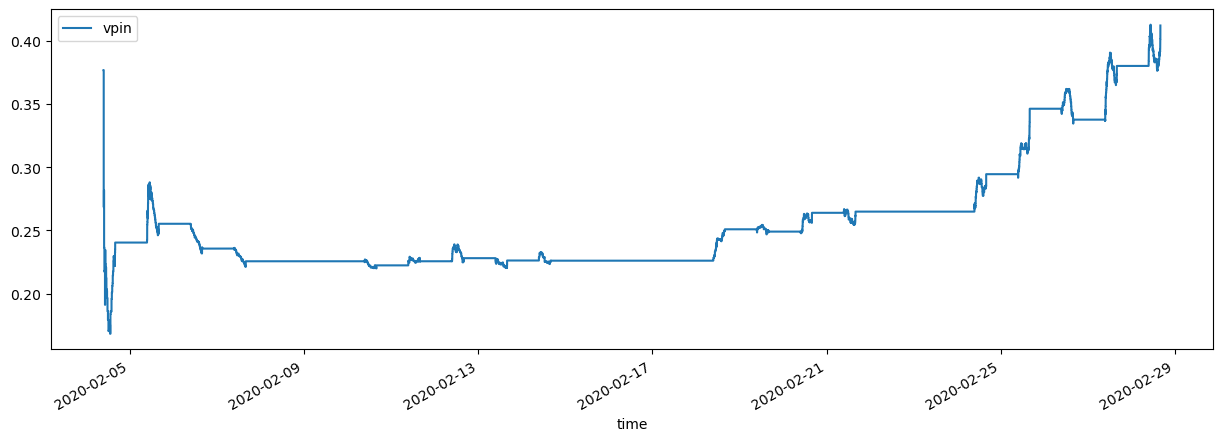

In [24]:
%%py
b.plot(drawstyle='steps-post')

# VPIN Problems
- [The Trouble With VPIN][VPINTROUBLE] based on research by Torben
  Andersen Oleg Bondarenko
- Volume is highly correlated with volatility
- Volumes are accumulated across trade dates
- Signal is highly dependent on starting time
- Attempts at reproducing the statistic leading into the e-mini flash
  crash show that it **lags** the crash

[VPINTROUBLE]: https://insight.kellogg.northwestern.edu/article/the_trouble_with_vpin "The Trouble With VPIN"

## [Rebuttal][VPINREBUTTAL]
> We appreciate the interest in our work, but feel strongly that they
> are confused by what we do and are incorrect in their claims and
> findings. Far from “replicating” our results, AB attack a
> methodology we do not advocate, an analysis we never performed, and
> conclusions we did not draw.

[VPINREBUTTAL]: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2062450 "VPIN Rebuttal"


# Further Reading

Multiple implementations of the PIN statistic exist in more academic
languages such as SAS and R.

## SAS
- [SAS implementation of PIN as in Easley, Kiefer, O'Hara and Paperman (1996)](https://kelley.iu.edu/nstoffma/ekop.html)
- [SAS implementation of PIN as in Easley, Hvidjkaer, and O'Hara (2002)](https://wrds-www.wharton.upenn.edu/pages/support/research-wrds/sample-programs/probability-informed-training-pin/)

## R
- [PIN: Measuring Asymmetric Information in Financial Markets with R by Paolo Zagaglia](https://journal.r-project.org/archive/2013-1/zagaglia.pdf)
- [pinbasic: An R Package for Fast and Stable Estimation of Static Models for the Probability of Informed Trading by Andreas Recktenwald](https://cran.r-project.org/web/packages/pinbasic/vignettes/pinbasicVignette.html)
- [InfoTrad: An R package for estimating the probability of informed trading by Duygu Çelik and Murat Tiniç](https://journal.r-project.org/archive/2018/RJ-2018-013/index.html)
- [PINstimation: An R Package for Estimating Models of Probability of Informed Trading by Montasser Ghachem and Oguz Ersan](https://dx.doi.org/10.2139/ssrn.4117946)

## VPIN Worked Example
- [From PIN to VPIN: An introduction to order flow toxicity by David Abada and José Yagüeb](https://www.elsevier.es/en-revista-the-spanish-review-financial-economics-332-articulo-from-pin-vpin-an-introduction-S2173126812000344)

> Although VPIN metric is conceived for the HFT environment, our
> results suggest that certain VPIN specifications provide proxies for
> adverse selection risk similar to those obtained by the PIN
> model. Thus, we consider that the key variable in the VPIN procedure
> is the number of buckets used and that VPIN can be a helpful device
> which is not exclusively applicable to the HFT world.